In [553]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

In [554]:
standard_scaler = StandardScaler()

In [555]:
train_df = pd.read_csv("../data/titanic/train.csv")
print(train_df.shape)
train_df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [556]:
test_df = pd.read_csv("../data/titanic/test.csv")
print(test_df.shape)
test_df.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Data Preparation

In [557]:
# data statistics
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [558]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [559]:
# drop all the rows where age is null 
train_df = train_df[~train_df["Age"].isna()]
train_df.shape

(714, 12)

In [560]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          529
Embarked         2
dtype: int64

In [561]:
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [562]:
# drop columns PassengerId, Name, Cabin
train_df = train_df.drop(["PassengerId", "Name", "Cabin", "Ticket"], axis = 1)
print(train_df.shape)
# drop all na values
train_df = train_df.dropna()
print(train_df.shape)
train_df.isna().sum()

(714, 8)
(712, 8)


Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [563]:
# drop columns PassengerId, Name, Cabin
test_df = test_df.drop(["PassengerId", "Name", "Cabin", "Ticket"], axis = 1)
print(test_df.shape)
mean_age = test_df["Age"].mean()
test_df["Age"] = test_df["Age"].fillna(mean_age)
mean_fare = test_df["Fare"].mean()
test_df["Fare"] = test_df["Fare"].fillna(mean_fare)
test_df.isna().sum()

(418, 7)


Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [564]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [565]:
print(test_df.shape)
test_df.head()

(418, 7)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [566]:
train_df["Embarked"].unique()

array(['S', 'C', 'Q'], dtype=object)

In [567]:
# normalize the data
train_df = pd.get_dummies(train_df, columns=["Sex"], prefix="Sex")
train_df['Sex_female'] = train_df['Sex_female'].astype("int")
train_df['Sex_male'] = train_df['Sex_male'].astype("int")
train_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_female,Sex_male
0,0,3,22.0,1,0,7.2500,S,0,1
1,1,1,38.0,1,0,71.2833,C,1,0
2,1,3,26.0,0,0,7.9250,S,1,0
3,1,1,35.0,1,0,53.1000,S,1,0
4,0,3,35.0,0,0,8.0500,S,0,1


In [568]:
# normalize the data
test_df = pd.get_dummies(test_df, columns=["Sex"], prefix="Sex")
test_df['Sex_female'] = test_df['Sex_female'].astype("int")
test_df['Sex_male'] = test_df['Sex_male'].astype("int")
test_df.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_female,Sex_male
0,3,34.5,0,0,7.8292,Q,0,1
1,3,47.0,1,0,7.0000,S,1,0
2,2,62.0,0,0,9.6875,Q,0,1
3,3,27.0,0,0,8.6625,S,0,1
4,3,22.0,1,1,12.2875,S,1,0


In [569]:
train_df = pd.get_dummies(train_df, columns=["Embarked"], prefix="Embarked")
train_df["Embarked_C"] = train_df["Embarked_C"].astype("int")
train_df["Embarked_Q"] = train_df["Embarked_Q"].astype("int")
train_df["Embarked_S"] = train_df["Embarked_S"].astype("int")
train_df = pd.get_dummies(train_df, columns=["Pclass"], prefix="Pclass")
train_df["Pclass_1"] = train_df["Pclass_1"].astype("int")
train_df["Pclass_2"] = train_df["Pclass_2"].astype("int")
train_df["Pclass_3"] = train_df["Pclass_3"].astype("int")
train_df.head()

,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,1,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1,1,0,0
4,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


In [570]:
test_df = pd.get_dummies(test_df, columns=["Embarked"], prefix="Embarked")
test_df["Embarked_C"] = test_df["Embarked_C"].astype("int")
test_df["Embarked_Q"] = test_df["Embarked_Q"].astype("int")
test_df["Embarked_S"] = test_df["Embarked_S"].astype("int")
test_df.head()
test_df = pd.get_dummies(test_df, columns=["Pclass"], prefix="Pclass")
test_df["Pclass_1"] = test_df["Pclass_1"].astype("int")
test_df["Pclass_2"] = test_df["Pclass_2"].astype("int")
test_df["Pclass_3"] = test_df["Pclass_3"].astype("int")
test_df.head()

,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,34.5,0,0,7.8292,0,1,0,1,0,0,0,1
1,47.0,1,0,7.0000,1,0,0,0,1,0,0,1
2,62.0,0,0,9.6875,0,1,0,1,0,0,1,0
3,27.0,0,0,8.6625,0,1,0,0,1,0,0,1
4,22.0,1,1,12.2875,1,0,0,0,1,0,0,1


In [571]:
# train_df["Age_scaled"] = standard_scaler.fit_transform(train_df[["Age"]])
# train_df.head()
# train_df["Fare_scaled"] = standard_scaler.fit_transform(train_df[["Fare"]])
# train_df.head()

In [572]:
# test_df["Age_scaled"] = standard_scaler.transform(test_df[["Age"]])
# test_df.head()
# test_df["Fare_scaled"] = standard_scaler.transform(test_df[["Fare"]])
# test_df.head()

In [573]:
# train_df = train_df.drop(["Age", "Fare"], axis=1)
# train_df.head()

In [574]:
# test_df = test_df.drop(["Age", "Fare"], axis=1)
# test_df.head()

In [575]:
features = [col for col in train_df.columns if col != "Survived"]
print(features)
X_train = train_df[features].to_numpy()
print(X_train.shape)
y_train = train_df[["Survived"]].to_numpy()
print(y_train.shape)

['Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3']
(712, 12)
(712, 1)


In [576]:
X_test = test_df.to_numpy()
print(X_test.shape)

(418, 12)


In [577]:
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

In [578]:
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
print(X_train_tensor.shape)
print(y_train_tensor.shape)
# y_train_tensor = y_train_tensor.squeeze()
# y_train_tensor = y_train_tensor
# print(y_train_tensor.shape)
X_test_tensor = torch.Tensor(X_test)
print(X_test_tensor.shape)
# print(y_train_tensor)

torch.Size([712, 12])
torch.Size([712, 1])
torch.Size([418, 12])


In [579]:
class NeuralNet(nn.Module):

    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [580]:
input_size = X_train_tensor.shape[1]
output_size = 1
print(input_size, output_size)
model = NeuralNet(input_size, output_size)

12 1


In [581]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)

In [582]:
num_epochs = 10000
loss_data = list()
for epoch in range(num_epochs):
    model.train()
    # forward pass
    outputs = model.forward(X_train_tensor)
    # compute loss
    loss = criterion(outputs, y_train_tensor)
    # running_loss += loss.item()
    loss_data.append(loss.item())
    # print(torch.tensor((torch.max(outputs, 1)))
    # print(y_train_tensor.shape)
    accuracy = (torch.round(torch.sigmoid(outputs)) == y_train_tensor).sum().item()
    # print(outputs)
    accuracy = accuracy/y_train_tensor.shape[0]
    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item(): 0.6f}, Accuracy: {accuracy: 0.6f}")

Epoch: 1, Loss:  0.681746, Accuracy:  0.595506
Epoch: 2, Loss:  0.681594, Accuracy:  0.594101
Epoch: 3, Loss:  0.681306, Accuracy:  0.594101
Epoch: 4, Loss:  0.680898, Accuracy:  0.594101
Epoch: 5, Loss:  0.680384, Accuracy:  0.592697
Epoch: 6, Loss:  0.679781, Accuracy:  0.588483
Epoch: 7, Loss:  0.679102, Accuracy:  0.587079
Epoch: 8, Loss:  0.678360, Accuracy:  0.587079
Epoch: 9, Loss:  0.677568, Accuracy:  0.589888
Epoch: 10, Loss:  0.676737, Accuracy:  0.592697
Epoch: 11, Loss:  0.675873, Accuracy:  0.592697
Epoch: 12, Loss:  0.674985, Accuracy:  0.591292
Epoch: 13, Loss:  0.674081, Accuracy:  0.595506
Epoch: 14, Loss:  0.673167, Accuracy:  0.596910
Epoch: 15, Loss:  0.672248, Accuracy:  0.596910
Epoch: 16, Loss:  0.671329, Accuracy:  0.598315
Epoch: 17, Loss:  0.670424, Accuracy:  0.596910
Epoch: 18, Loss:  0.669528, Accuracy:  0.595506
Epoch: 19, Loss:  0.668669, Accuracy:  0.592697
Epoch: 20, Loss:  0.667840, Accuracy:  0.591292
Epoch: 21, Loss:  0.667030, Accuracy:  0.591292
E

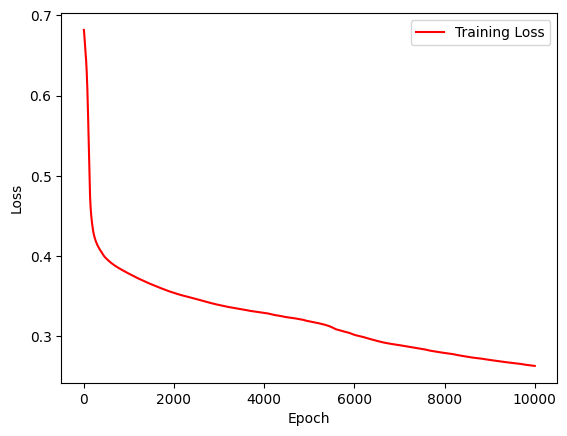

In [583]:
epoch_count = range(1, num_epochs + 1)
plt.plot(epoch_count, loss_data, 'r')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();


In [584]:
model.eval()
with torch.no_grad():
    predictions = model.forward(X_test_tensor)
    predictions = torch.round(torch.sigmoid(predictions))
    predictions = predictions.squeeze().to(torch.int).numpy()
    # print(predictions)

In [585]:
results = list()
passengerId = list(pd.read_csv("../data/titanic/test.csv")["PassengerId"])
for i, pId in enumerate(passengerId):
    results.append([pId, predictions[i]])
# print(results)

In [586]:
results_df = pd.DataFrame(results, columns=["PassengerId", "Survived"])
results_df.head()
print(results_df.shape)

(418, 2)


In [587]:
# save the results
# results_df.to_csv("submission.csv", index=False)